# Protocol for Kinase-Substrate Enrichment Analysis (KSEA)

This IPython notebook accompanies the chapter 'Phosphoproteomics-based profiling of kinase activities in cancer cell' in the book 'Methods of Molecular Biology: Cancer Systems Biology' from Springer, 2016.

The script aims to demonstrate the methodology of KSEA, to facilitate grasping the operations performed in the provided code, and to enable reproduction of the implementation in other programming languages where required.

In [1]:
# Import useful libraries
import numpy as np
import pandas as pd

# Import required libraries for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Get working directory path
import os
import sys
wd = os.path.dirname(os.getcwd())

# Magic
%matplotlib inline

### 1. Loading the data

In order to perform the described kinase enrichment analysis, we load the data into a Pandas DataFrame. Here, we use the data from <em>de Graaf et al., 2014</em> for demonstration of KSEA. The data is available as supplemental material to the article online under http://mcponline.org/content/13/9/2426/suppl/DC1. The dataset of interest can be found in the Supplemental Table 2.

When downloading the dataset from the internet, it will be provided as Excel spreadsheet. For the use in this script, it will have to saved as csv-file, using the 'Save As' function in Excel.

In the accompanying github repository, we will provide an already processed csv-file together with the code for KSEA.

In [3]:
# Read data
data_raw = pd.read_csv(wd+'/data/deGraaf_2014_jurkat.csv', sep=',', header=0)

# Filter for those p-sites that were matched ambiguously
data_reduced = data_raw[~data_raw['Proteins'].str.contains(';')]

# Create identifier for each phosphorylation site, e.g. P06239_S59 for the Serine 59 in the protein Lck
data_reduced.loc[:, 'ID'] = data_reduced['Proteins'] + '_' + data_reduced['Amino acid'] + \
    data_reduced['Positions within proteins']
data_indexed = data_reduced.set_index('ID')

# Extract only relevant columns
data_relevant = data_indexed[[x for x in data_indexed if x.startswith('Average')]]

# Rename columns
data_relevant.columns = [x.split()[-1] for x in data_relevant]

# Convert abundaces into fold changes compared to control (0 minutes after stimulation)
data_fc = data_relevant.sub(data_relevant['0min'], axis=0)
data_fc.drop('0min', axis=1, inplace=True)

# Also extract the p-values for the fold changes
data_p_value = data_indexed[[x for x in data_indexed if x.startswith('p value') and x.endswith('vs0min')]]
data_p_value.columns = [x.split('_')[-1].split('vs')[0] + 'min' for x in data_p_value]
data_p_value = data_p_value.astype('float') # Excel saved the p-values as strings, not as floating point numbers

print data_fc.head()
print data_p_value.head()

                 5min     10min     20min     30min     60min
ID                                                           
A0AVK6_S71  -0.319306 -0.484960 -0.798082 -0.856103 -0.928753
A0FGR8_S743 -0.856661 -0.981951 -1.500412 -1.441868 -0.861470
A0FGR8_S758 -1.445386 -2.397915 -2.692994 -2.794762 -1.553398
A0FGR8_S691  0.271458  0.264596  0.501685  0.461984  0.655501
A0JLT2_S226 -0.080786  1.069710  0.519780  0.520883 -0.296040
                 5min     10min     20min     30min     60min
ID                                                           
A0AVK6_S71   1.842767  2.279082  5.763681  3.891291  7.415421
A0FGR8_S743  2.004806  2.109405  4.522267  1.961858  1.664565
A0FGR8_S758  2.587950  6.394761  5.092488  5.499864  2.883937
A0FGR8_S691  0.396676  0.450902  0.987817  0.723807  0.983530
A0JLT2_S226  0.146437  3.101091  1.263347  1.039343  0.365879


### 2. Import prior-knowledge kinase-substrate relationships from PhosphoSitePlus

In the following example, we use the data from the PhosphoSitePlus database, which can be downloaded here: http://www.phosphosite.org/staticDownloads.action. 

Consider, that the downloaded file contains a disclaimer at the top of the file, which has to be removed before the file can be used as described below.

In [4]:
# Read data
ks_rel = pd.read_csv(wd+'/data/PhosphoSitePlus.txt', sep='\t') 
# The data from the PhosphoSitePlus database is not provided as comma-separated value file (csv), 
# but instead, a tab = \t delimits the individual cells

# Restrict the data on interactions in the organism of interest
ks_rel_human = ks_rel.loc[(ks_rel['KIN_ORGANISM'] == 'human') & (ks_rel['SUB_ORGANISM'] == 'human')]

# Create p-site identifier of the same format as before
ks_rel_human.loc[:, 'psite'] = ks_rel_human['SUB_ACC_ID'] + '_' + ks_rel_human['SUB_MOD_RSD']

# Create adjencency matrix (links between kinases (columns) and p-sites (rows) are indicated with a 1, NA otherwise)
ks_rel_human.loc[:, 'value'] = 1
adj_matrix = pd.pivot_table(ks_rel_human, values='value', index='psite', columns='GENE', fill_value=0)
print adj_matrix.head()
print adj_matrix.sum(axis=0).sort_values(ascending=False).head()

GENE          AAK1  ABL1  ABL2  ACVR1B  ACVRL1  ADRBK1  ADRBK2  AKT1  AKT2  \
psite                                                                        
A1KXE4_T57       0     0     0       0       0       0       0     0     0   
A1X283_Y508      0     0     0       0       0       0       0     0     0   
A2RUS2_S472      0     0     0       0       0       0       0     0     0   
A2RUS2_S490      0     0     0       0       0       0       0     0     0   
A6NKT7_S1276     0     0     0       0       0       0       0     0     0   

GENE          AKT3  ...    VRK2  VRK3  WEE1  WNK1  WNK2  WNK3  WNK4  YES1  \
psite               ...                                                     
A1KXE4_T57       0  ...       0     0     0     0     0     0     0     0   
A1X283_Y508      0  ...       0     0     0     0     0     0     0     0   
A2RUS2_S472      0  ...       0     0     0     0     0     0     0     0   
A2RUS2_S490      0  ...       0     0     0     0     0     0     0 

# 3. KSEA

## 3.1 Quick start for KSEA

Together with this tutorial, we will provide an implementation of KSEA as custom Python functions. Examplary, the use of the function for the dataset by de Graaf et al. could look like this.

In [5]:
# Add the parent dictionary to the path so that python can find the script there
sys.path.insert(0, wd+'/src/')

# import function to perform the Delta count method of KSEA
from ksea import ksea_delta

score, p_value = ksea_delta(data_fc=data_fc['5min'],
                          p_values=data_p_value['5min'],
                          interactions=adj_matrix,
                          )
print pd.DataFrame({'score': score, 'p_value': p_value}).head()

             p_value  score
AKT1    1.492353e-10      8
ATM     1.886071e-03      1
ATR     2.526158e-01     -1
AURKB   1.738389e-16     -1
CAMK2A  5.208205e-07      1


In [6]:
# Import all functions for KSEA (ksea_delta, ksea_mean, ksea_mean_alt)
from ksea import *

# Calculate the KSEA scores for  all data with the ksea_mean method
activity_mean = pd.DataFrame({c: ksea_mean(data_fc=data_fc[c],
                                           interactions=adj_matrix,
                                           mP=data_fc.values.mean(),
                                           delta=data_fc.values.std())[0]
                              for c in data_fc})
activity_mean = activity_mean[['5min', '10min', '20min', '30min', '60min']]
print activity_mean.head()

# Calculate the KSEA scores for  all data with the ksea_mean method, using the median
activity_median = pd.DataFrame({c: ksea_mean(data_fc=data_fc[c],
                                             interactions=adj_matrix,
                                             mP=data_fc.values.mean(),
                                             delta=data_fc.values.std(), median=True)[0]
                              for c in data_fc})
activity_median = activity_median[['5min', '10min', '20min', '30min', '60min']]
print activity_median.head()

# Calculate the KSEA scores for  all data with the ksea_mean_alt method
activity_mean_alt = pd.DataFrame({c: ksea_mean_alt(data_fc=data_fc[c],
                                                   p_values=data_p_value[c],
                                                   interactions=adj_matrix,
                                                   mP=data_fc.values.mean(),
                                                   delta=data_fc.values.std())[0]
                                    for c in data_fc})
activity_mean_alt = activity_mean_alt[['5min', '10min', '20min', '30min', '60min']]
print activity_mean_alt.head()

# Calculate the KSEA scores for  all data with the ksea_mean method, using the median
activity_median_alt = pd.DataFrame({c: ksea_mean_alt(data_fc=data_fc[c],
                                                    p_values=data_p_value[c],
                                                    interactions=adj_matrix,
                                                    mP=data_fc.values.mean(),
                                                    delta=data_fc.values.std(),
                                                    median=True)[0]
                                    for c in data_fc})
activity_median_alt = activity_median_alt[['5min', '10min', '20min', '30min', '60min']]
print activity_median_alt.head()

# Calculate the KSEA scores for  all data with the ksea_delta method
activity_delta = pd.DataFrame({c: ksea_delta(data_fc=data_fc[c],
                                             p_values=data_p_value[c],
                                             interactions=adj_matrix)[0]
                               for c in data_fc})
activity_delta = activity_delta[['5min', '10min', '20min', '30min', '60min']]
print activity_delta.head()

            5min     10min     20min     30min     60min
AKT1    0.247593  0.289220  0.302999  0.169472  0.076125
ATM    -0.061485 -0.343459 -0.283472 -0.049524 -0.165507
ATR    -0.222859 -0.552151 -0.603683 -0.494195 -0.565925
AURKB   0.737892  0.113715 -0.037972 -0.022809 -0.127491
CAMK2A  0.288786  0.032288 -0.095293  0.116467 -0.006405
            5min     10min     20min     30min     60min
AKT1    0.128443  0.225658  0.314207  0.123895  0.041593
ATM    -0.127540 -0.414224 -0.167229  0.045189 -0.185755
ATR    -0.264612 -0.312339 -0.504776 -0.431758 -0.494161
AURKB   0.084064 -0.134791 -0.103995 -0.112923 -0.045685
CAMK2A -0.168092  0.137151 -0.231520 -0.067075 -0.119413
            5min     10min     20min     30min     60min
AKT1    0.689030  0.753743  0.670029  0.522522  0.136480
ATM     0.075757 -0.436289 -1.333812 -1.193118 -0.077833
ATR    -0.504434 -1.096649 -1.130404 -1.266480 -0.804241
AURKB   0.923970  0.069651 -0.120200 -0.138074 -0.227995
CAMK2A  0.556722 -0.174010  0.0

/Library/Python/2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


            5min     10min     20min     30min     60min
AKT1    0.682230  0.671451  0.751518  0.665222  0.346784
ATM     0.365852 -0.330110 -1.333812 -1.193118 -0.218312
ATR    -0.504434 -1.144993 -1.150413 -1.339842 -0.708942
AURKB  -0.518690 -0.626140 -0.419121 -0.671761 -0.613397
CAMK2A  0.771158 -0.146282  0.284781  0.808217 -0.171924
        5min  10min  20min  30min  60min
AKT1       8     12     12      7      2
ATM        1     -1     -2     -2     -1
ATR       -1     -4     -4     -4     -7
AURKB     -1     -3     -3     -3     -1
CAMK2A     1      0      0      1      0


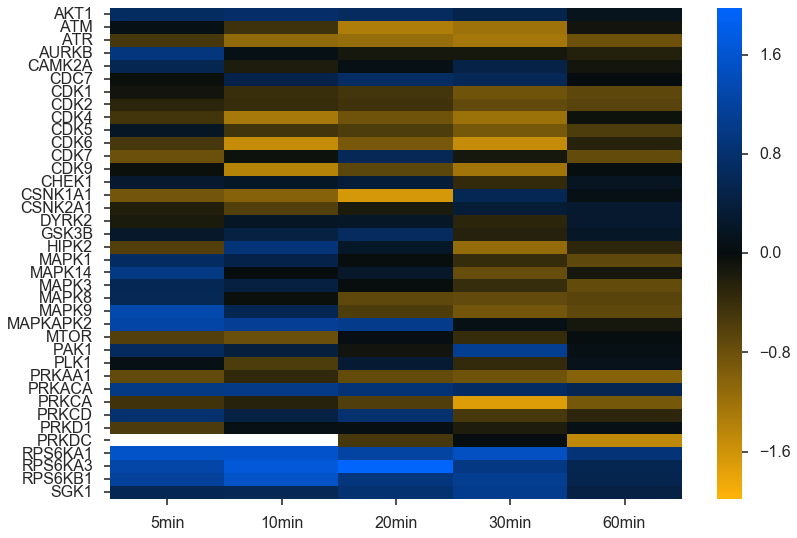

In [7]:
sns.set(context='poster', style='ticks')
sns.heatmap(activity_mean_alt, cmap=sns.blend_palette([sns.xkcd_rgb['amber'], 
                                                       sns.xkcd_rgb['almost black'], 
                                                       sns.xkcd_rgb['bright blue']], 
                                                      as_cmap=True))
plt.show()

In de Graaf et al., they associated (amongst others) the Casein kinase II alpha (CSNK2A1) with higher activity after prolonged stimulation with prostaglandin E2. Here, we plot the activity scores of CSNK2A1 for all three methods of KSEA, which are in good agreement.

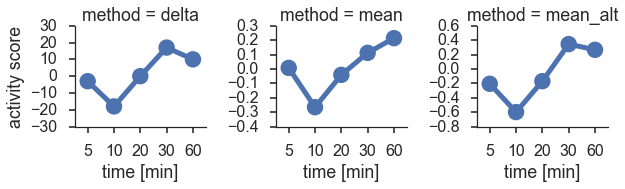

In [8]:
kinase='CSNK2A1'
df_plot = pd.DataFrame({'mean': activity_mean.ix[kinase],
                        'delta': activity_delta.ix[kinase],
                        'mean_alt': activity_mean_alt.ix[kinase]})
df_plot['time [min]'] = [5, 10, 20, 30, 60]
df_plot = pd.melt(df_plot, id_vars='time [min]', var_name='method', value_name='activity score')
g = sns.FacetGrid(df_plot, col='method', sharey=False, size=3, aspect=1)
g = g.map(sns.pointplot, 'time [min]', 'activity score')
plt.subplots_adjust(top=.82)
plt.show()

## 3.2. KSEA in detail

In the following, we show in detail the computations that are carried out inside the provided functions. Let us concentrate on a single condition (60 minutes after stimulation with prostaglandin E2) and a single kinase (CDK1).

In [9]:
data_condition = data_fc['60min'].copy()

p_values = data_p_value['60min']

kinase = 'CDK1'

In [10]:
substrates = adj_matrix[kinase].replace(0, np.nan).dropna().index

detected_p_sites = data_fc.index

intersect = list(set(substrates).intersection(detected_p_sites))

### 3.2.1. Mean method

In [11]:
mS = data_condition.ix[intersect].mean()
mP = data_fc.values.mean()
m = len(intersect)
delta = data_fc.values.std()
z_score = (mS - mP) * np.sqrt(m) * 1/delta
from scipy.stats import norm
p_value_mean = norm.sf(abs(z_score))
print mS, p_value_mean

-0.441268760191 9.26894825183e-07


### 3.2.2. Alternative Mean method

In [12]:
cut_off = -np.log10(0.05)
set_alt = data_condition.ix[intersect].where(p_values.ix[intersect] > cut_off).dropna()
mS_alt = set_alt.mean()
z_score_alt = (mS_alt - mP) * np.sqrt(len(set_alt)) * 1/delta
p_value_mean_alt = norm.sf(abs(z_score_alt))
print mS_alt, p_value_mean_alt

-0.680835732551 1.26298232031e-13


### 3.2.3. Delta Method

In [13]:
cut_off = -np.log10(0.05)

score_delta = len(data_condition.ix[intersect].where((data_condition.ix[intersect] > 0) & 
                                                     (p_values.ix[intersect] > cut_off)).dropna()) -\
                len(data_condition.ix[intersect].where((data_condition.ix[intersect] < 0) & 
                                                       (p_values.ix[intersect] > cut_off)).dropna())
M = len(data_condition) 
n = len(intersect) 
N = len(np.where(p_values.ix[adj_matrix.index.tolist()] > cut_off)[0])
from scipy.stats import hypergeom
hypergeom_dist = hypergeom(M, n, N)

p_value_delta = hypergeom_dist.pmf(len(p_values.ix[intersect].where(p_values.ix[intersect] > cut_off).dropna()))
print score_delta, p_value_delta

-58 8.42823410966e-119
